# Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Cultivo

In [2]:

data = {
    'País': ['Bolivia', 'Colombia', 'Peru', 'Afganistán', 'Myanmar','Laos', 'Mexico'],
    'Coca': [26000, 119794.83, 58499.21, None, None, None, None],
    'Opio': [None, 408.76, None, 187414.29, 43223.08, 4443.38, 20.000]
}

df_cultivo = pd.DataFrame(data)

In [3]:
df_cultivo.head()

,País,Coca,Opio
0,Bolivia,26000.00,NaN
1,Colombia,119794.83,408.76
2,Peru,58499.21,NaN
3,Afganistán,NaN,187414.29
4,Myanmar,NaN,43223.08


<Figure size 1000x600 with 0 Axes>

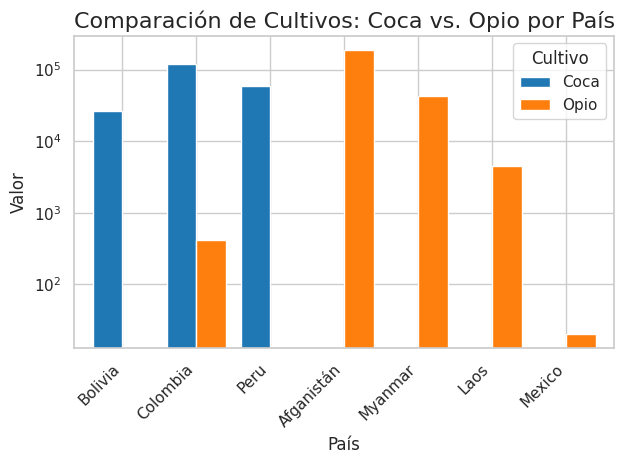

In [4]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))


df_cultivo.set_index('País')[['Coca', 'Opio']].plot(kind='bar', width=0.8, logy=True, color=['#1f77b4', '#ff7f0e'])

plt.title('Comparación de Cultivos: Coca vs. Opio por País', fontsize=16)
plt.xlabel('País', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cultivo', labels=['Coca', 'Opio'])

plt.tight_layout()
plt.show()

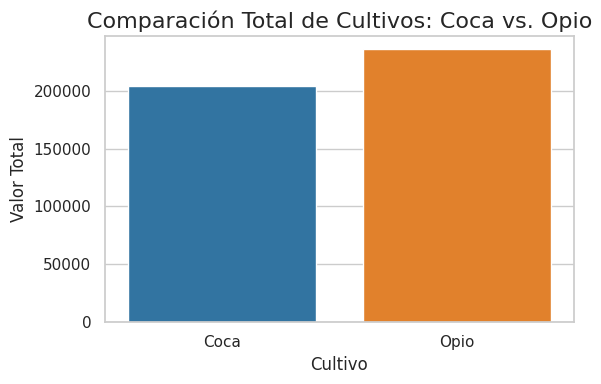

In [15]:
total_coca = df_cultivo['Coca'].sum()
total_opio = df_cultivo['Opio'].sum()

# Crear un DataFrame con los totales
df_total = pd.DataFrame({'Cultivo': ['Coca', 'Opio'], 'Valor': [total_coca, total_opio]})

# Graficar
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

# Graficar barras
sns.barplot(x='Cultivo', y='Valor', data=df_total, palette=['#1f77b4', '#ff7f0e'])

plt.title('Comparación Total de Cultivos: Coca vs. Opio', fontsize=16)
plt.xlabel('Cultivo', fontsize=12)
plt.ylabel('Valor Total', fontsize=12)

plt.tight_layout()
plt.show()

# Produccion

In [19]:
df_produccion = pd.read_csv('../data/produccion.csv')

In [20]:
df_produccion

,País,laboratorio_coca,cat_coca,laboratorio_opio,cat_opio,laboratorio_meta,cat_meta
0,Bolivia,3446.0,Alta,NaN,Sin dato,NaN,Sin dato
1,China,NaN,Sin dato,NaN,Sin dato,479.0,Alta
2,Colombia,24514.0,Alta,NaN,Sin dato,NaN,Sin dato
3,Estados Unidos,NaN,Sin dato,NaN,Sin dato,2806.0,Alta
4,Grecia,NaN,Sin dato,22.0,Alta,NaN,Sin dato
5,Malasia,NaN,Sin dato,40.0,Alta,NaN,Sin dato
6,Peru,2202.0,Alta,NaN,Sin dato,NaN,Sin dato
7,República Checa,NaN,Sin dato,19.0,Alta,1021.0,Alta


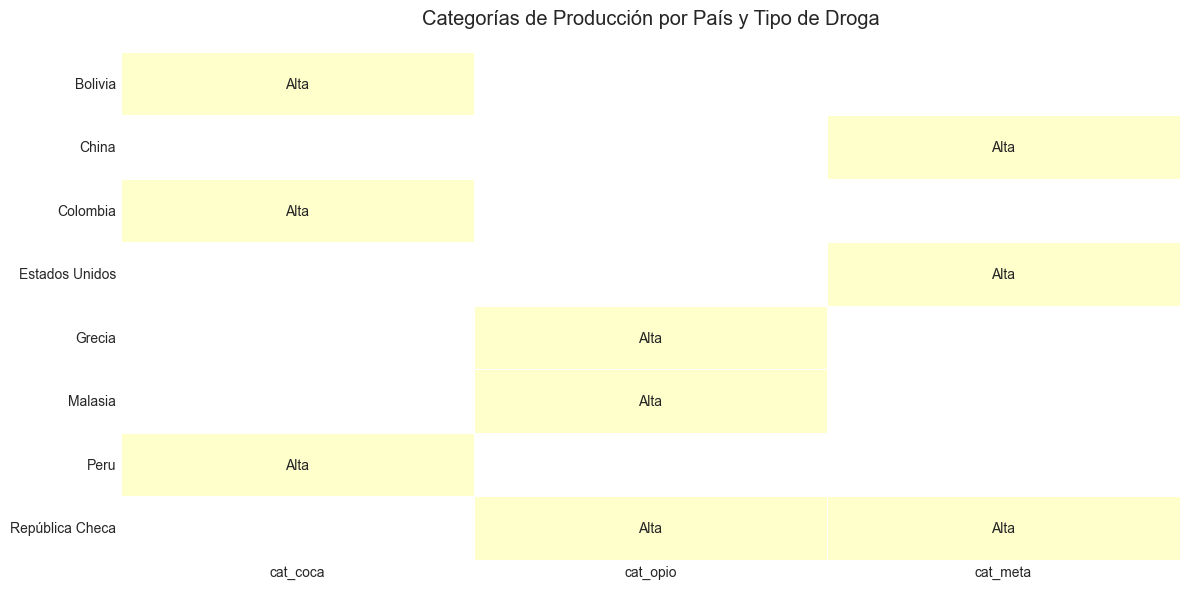

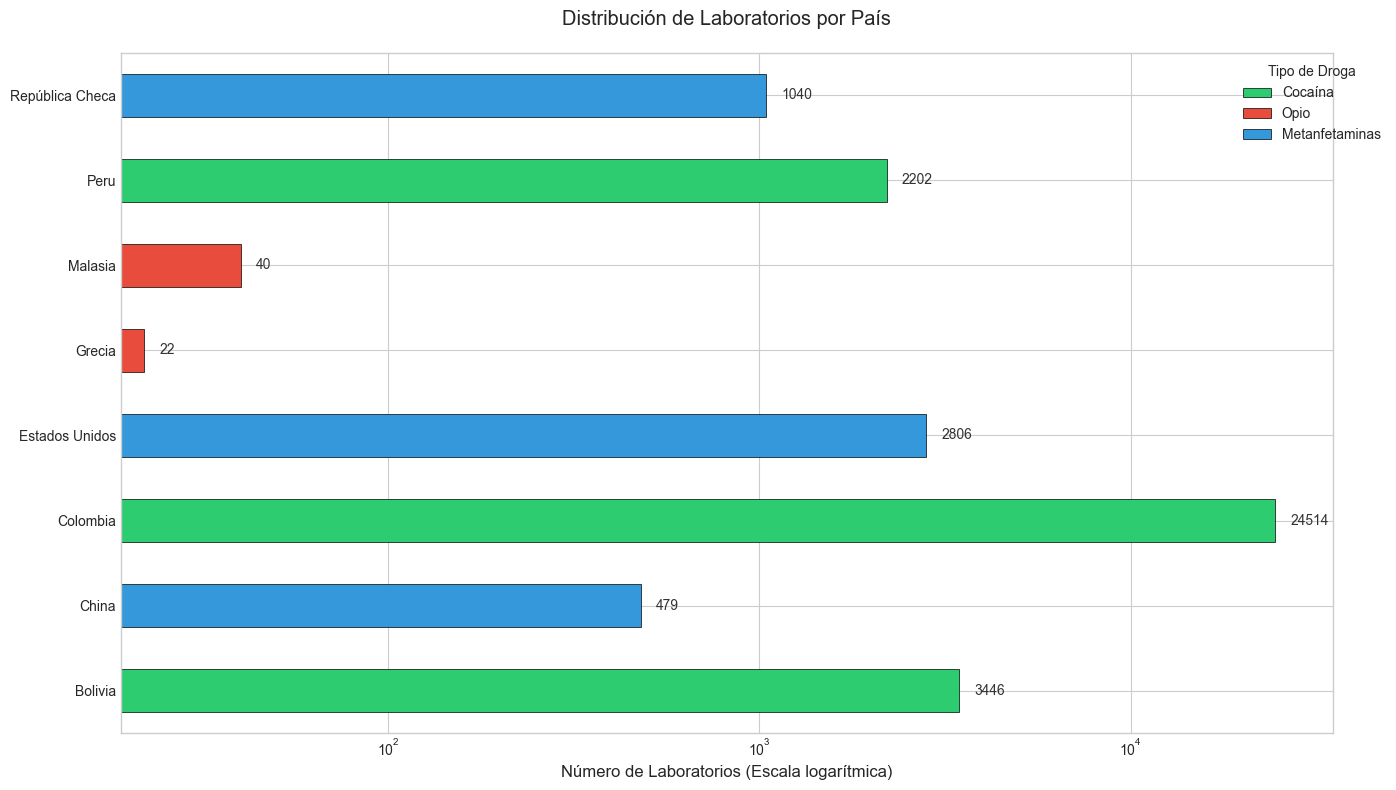

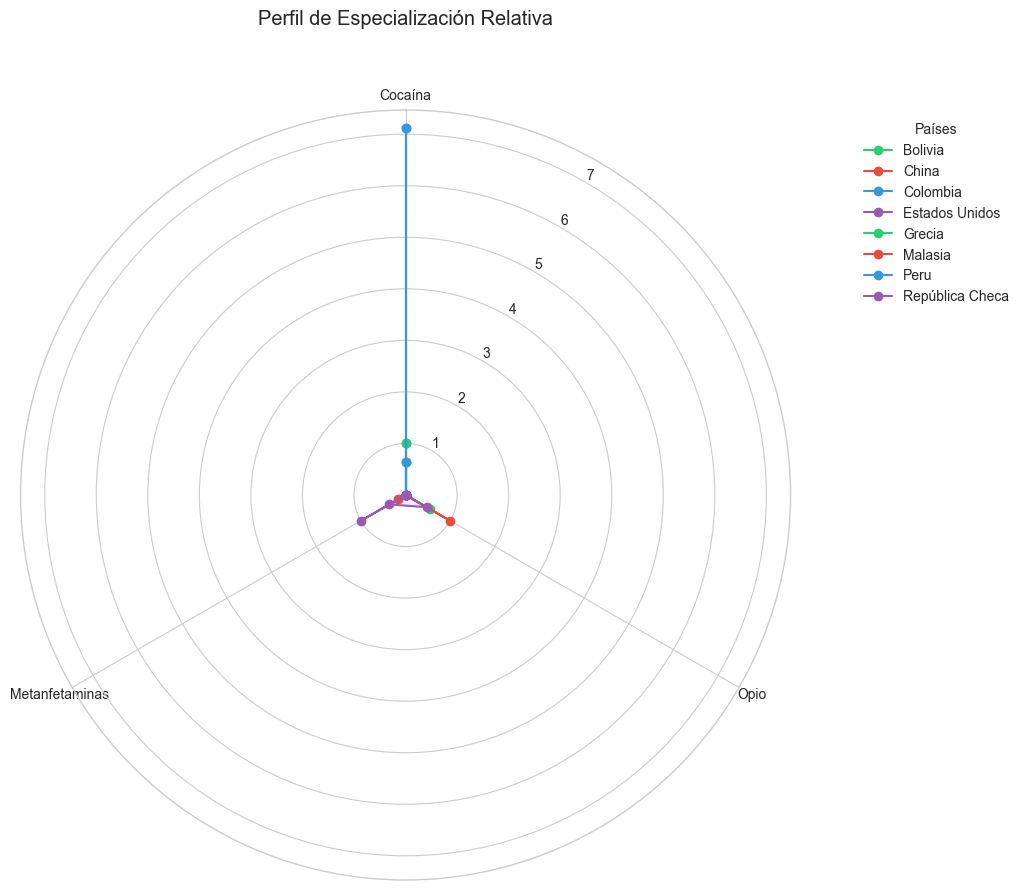

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración estética
plt.style.use('seaborn-whitegrid')
palette = sns.color_palette("Set2", 3)

# 1. Mapa de calor de categorías de producción
fig, ax = plt.subplots(figsize=(12, 6))
categorias = df_produccion[['cat_coca', 'cat_opio', 'cat_meta']].replace('Sin dato', np.nan)
sns.heatmap(categorias.apply(lambda x: x.map({'Alta':1, 'Media':0.5, 'Baja':0.25})), 
           annot=categorias,
           cmap='YlOrRd',
           linewidths=0.5,
           cbar=False,
           fmt='',
           ax=ax)

ax.set_yticklabels(df_produccion['País'], rotation=0)
ax.set_title('Categorías de Producción por País y Tipo de Droga', pad=20)
ax.set_xlabel('')
plt.tight_layout()
plt.show()

# 2. Gráfico de barras apiladas para laboratorios
laboratorios = df_produccion[['laboratorio_coca', 'laboratorio_opio', 'laboratorio_meta']]
laboratorios.columns = ['Cocaína', 'Opio', 'Metanfetaminas']

ax = laboratorios.plot(kind='barh', 
                      stacked=True, 
                      figsize=(14, 8),
                      color=['#2ecc71', '#e74c3c', '#3498db'],
                      edgecolor='black')

ax.set_yticklabels(df_produccion['País'])
ax.set_title('Distribución de Laboratorios por País', pad=20)
ax.set_xlabel('Número de Laboratorios (Escala logarítmica)')
ax.set_xscale('log')
ax.legend(title='Tipo de Droga', bbox_to_anchor=(1.05, 1))

# Añadir etiquetas de totales
for i, total in enumerate(laboratorios.sum(axis=1)):
    if total > 0:
        ax.text(total*1.1, i, f'{total:.0f}', va='center', color='#333333')

plt.tight_layout()
plt.show()

# 3. Gráfico de red de especialización
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

angles = np.linspace(0, 2*np.pi, 3, endpoint=False)
labels = ['Cocaína', 'Opio', 'Metanfetaminas']

for idx, row in df_produccion.iterrows():
    values = [
        row['laboratorio_coca']/3446 if not np.isnan(row['laboratorio_coca']) else 0,
        row['laboratorio_opio']/40 if not np.isnan(row['laboratorio_opio']) else 0,
        row['laboratorio_meta']/2806 if not np.isnan(row['laboratorio_meta']) else 0
    ]
    
    values += values[:1]  # Cerrar el polígono
    ax.plot(np.concatenate([angles, [angles[0]]]), 
           values, 
           marker='o', 
           label=row['País'])
    ax.fill(np.concatenate([angles, [angles[0]]]), values, alpha=0.1)

ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
plt.xticks(angles, labels)
ax.set_rlabel_position(30)
plt.legend(bbox_to_anchor=(1.3, 1), title='Países')
plt.title('Perfil de Especialización Relativa', y=1.1)
plt.show()

# Consumo

In [23]:
df_consumo = pd.read_csv('../data/consumo.csv')

In [24]:
df_consumo

,País,Cocaína,Cannabis,Metanfetaminas,Opioides,Categoría_Cocaína,Categoría_Cannabis,Categoría_Metanfetaminas,Categoría_Opioides
0,Albania,2.50,5.60,0.10,0.00,Alta,Media,Muy Baja,Sin dato
1,Alemania,1.03,6.62,1.15,0.36,Media,Media,Alta,Baja
2,Argelia,0.01,0.52,0.03,0.00,Muy baja,Muy baja,Muy Baja,Sin dato
3,Argentina,1.20,5.67,0.00,0.19,Media,Media,Sin dato,Muy baja
4,Australia,0.00,10.80,1.73,3.10,Sin dato,Alta,Alta,Alta
...,...,...,...,...,...,...,...,...,...
78,Turquía,0.05,0.84,0.02,0.00,Muy baja,Muy baja,Muy Baja,Sin dato
79,Túnez,0.10,3.97,0.00,0.00,Muy baja,Media,Sin dato,Sin dato
80,Ucrania,0.42,2.51,0.51,0.00,Baja,Baja,Media,Sin dato
81,Uruguay,2.00,10.73,0.11,2.54,Alta,Alta,Muy Baja,Alta


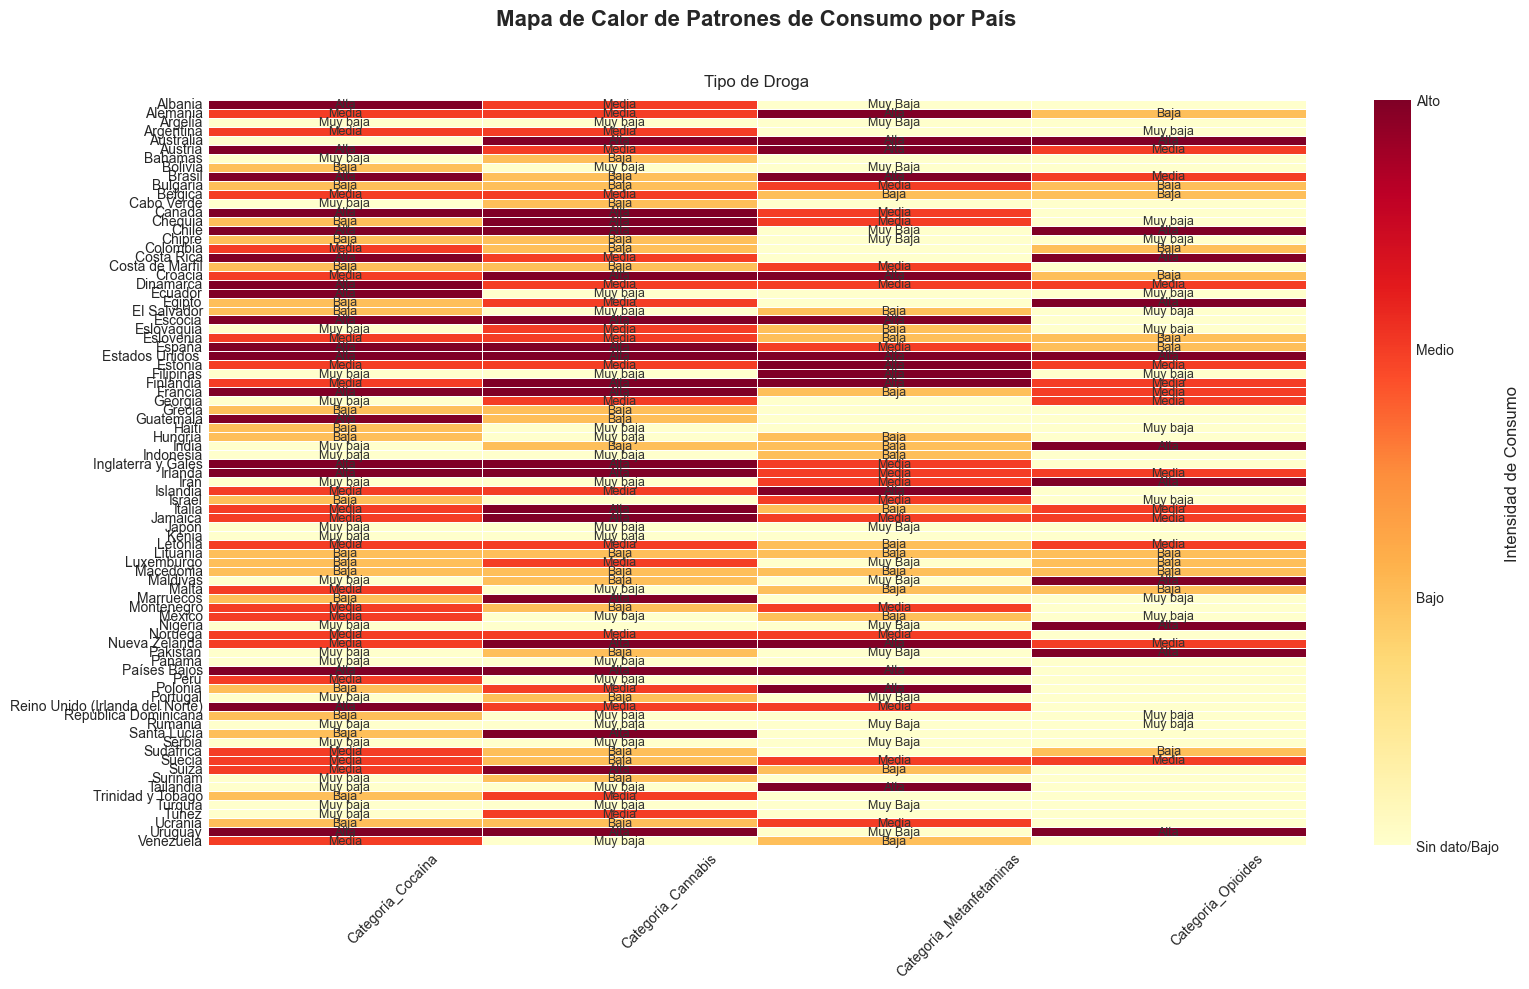

IndexError: index 0 is out of bounds for axis 0 with size 0

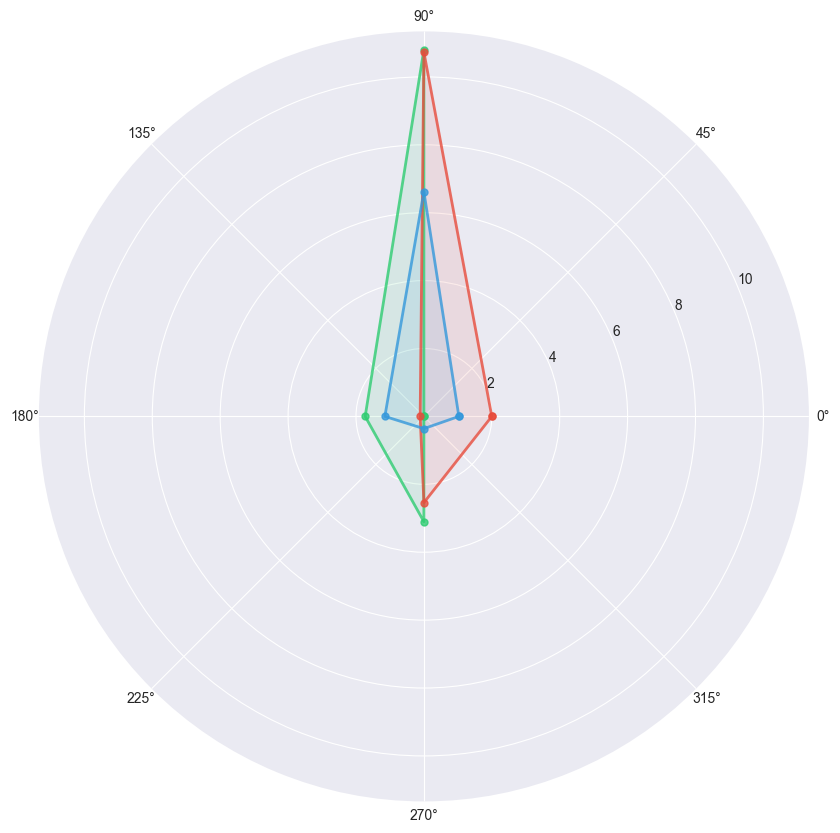

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preprocesamiento correcto de datos
# Crear copia para no modificar el dataframe original
categorias = df_consumo[['Categoría_Cocaína', 'Categoría_Cannabis', 
                        'Categoría_Metanfetaminas', 'Categoría_Opioides']].copy()

# Mapeo completo y consistente (atención a mayúsculas y espacios)
orden_categorias = {
    'Alta': 3,
    'Media': 2,
    'Baja': 1,
    'Muy Baja': 0,  # Original tiene 'Muy Baja' con espacio y mayúscula
    'Muy baja': 0,  # Versión alternativa detectada en algunos registros
    'Sin dato': 0
}

# Aplicar mapeo columna por columna
numeric_cat = categorias.apply(lambda col: col.map(orden_categorias))

# 2. Generar heatmap con parámetros validados
plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    numeric_cat,
    annot=categorias.replace({'Sin dato': ''}),  # Limpiar etiquetas
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Intensidad de Consumo'},
    yticklabels=df_consumo['País'],
    fmt='',  # Formato textual
    annot_kws={'fontsize': 9, 'color': '#333333'},
    vmin=0,  # Establecer límites claros
    vmax=3
)

# 3. Personalización avanzada
ax.set_title('Mapa de Calor de Patrones de Consumo por País\n', 
            fontsize=16, fontweight='bold')
ax.set_xlabel('\nTipo de Droga', fontsize=12, labelpad=10)
ax.xaxis.set_label_position('top') 
plt.xticks(rotation=45, ha='left')

# 4. Barra de color personalizada
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Sin dato/Bajo', 'Bajo', 'Medio', 'Alto'])

plt.tight_layout()
plt.show()

# 2. Radar Chart comparativo (países seleccionados)
def radar_chart_comparativo(paises):
    categorias = ['Cocaína', 'Cannabis', 'Metanfetaminas', 'Opioides']
    N = len(categorias)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    for pais in paises:
        datos = df_consumo[df_consumo['País'] == pais][categorias].values[0]
        datos = np.append(datos, datos[0])
        
        angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
        angles += angles[:1]
        
        ax.plot(angles, datos, marker='o', markersize=5, linewidth=2,
               label=pais, alpha=0.8)
        ax.fill(angles, datos, alpha=0.1)
    
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categorias)
    ax.set_rlabel_position(30)
    plt.legend(bbox_to_anchor=(1.3, 1), title='Países')
    plt.title('Comparación de Perfiles de Consumo', y=1.1)
    plt.show()

radar_chart_comparativo(['Australia', 'Uruguay', 'Alemania', 'Estados Unidos'])

# 3. Matriz de dispersión con burbujas
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df_consumo,
    x='Cannabis',
    y='Opioides',
    size='Cocaína',
    hue='Metanfetaminas',
    sizes=(50, 500),
    palette='viridis',
    alpha=0.8
)

plt.xscale('log')
plt.yscale('log')
plt.title('Relación Multivariable de Consumo', fontsize=14)
plt.xlabel('Consumo de Cannabis (log)', fontsize=12)
plt.ylabel('Consumo de Opioides (log)', fontsize=12)

# Leyenda mejorada
h, l = scatter.get_legend_handles_labels()
plt.legend(h[1:5], l[1:5], 
          bbox_to_anchor=(1.05, 1), 
          title='Metanfetaminas',
          borderaxespad=0)

size_legend = plt.legend(h[5:], l[5:], 
                        bbox_to_anchor=(1.05, 0.7),
                        title='Cocaína',
                        frameon=False)
plt.gca().add_artist(size_legend)

# 4. Gráfico de violín mejorado para distribución de consumo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
drogas = ['Cocaína', 'Cannabis', 'Metanfetaminas', 'Opioides']

for ax, droga in zip(axes.flatten(), drogas):
    sns.violinplot(data=df_consumo, 
                  x=droga, 
                  inner='quartile',
                  cut=0,
                  palette='rocket',
                  ax=ax)
    ax.set_xscale('log')
    ax.set_title(f'Distribución de {droga}', fontsize=12)
    ax.set_xlabel('Porcentaje de Consumo (log)', fontsize=10)

plt.tight_layout()
plt.show()

# Trafico

In [15]:
df_trafico = pd.read_csv('../data/trafico.csv')

In [16]:
df_trafico

,País,Cocaína,Cannabis,Metanfetaminas,Heroína
0,Sri Lanka,177609.980000,1731.53,4567.113736,145917.640000
1,Australia,159530.390000,NaN,85635.359116,142964.640000
2,Finlandia,94686.555524,5751.15,14874.141876,53374.333333
3,Palestina,75000.000000,4464.29,NaN,NaN
4,Moldavia,71174.380000,NaN,NaN,126448.890000
...,...,...,...,...,...
85,Catar,NaN,NaN,136314.067612,136314.070000
86,Bangladés,NaN,172.40,NaN,164051.000000
87,Azerbaiyán,NaN,3938.46,6000.000000,17688.680000
88,Arabia Saudita,NaN,6620.37,NaN,NaN


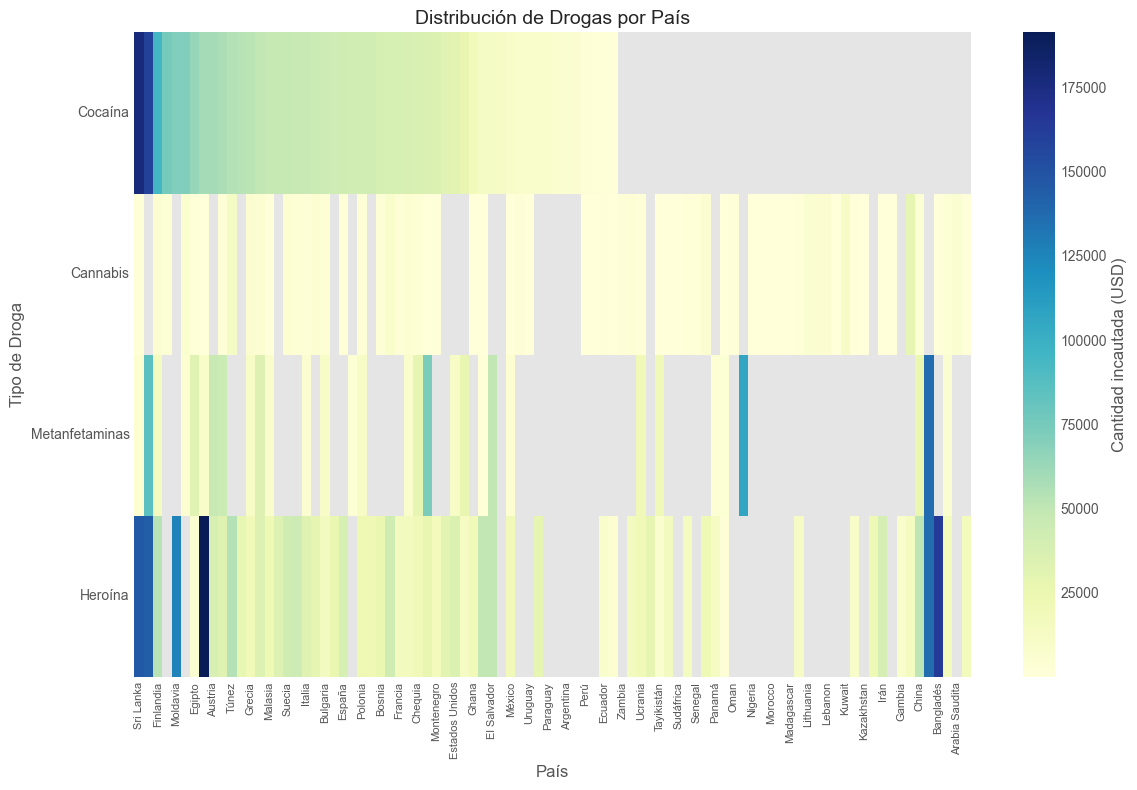

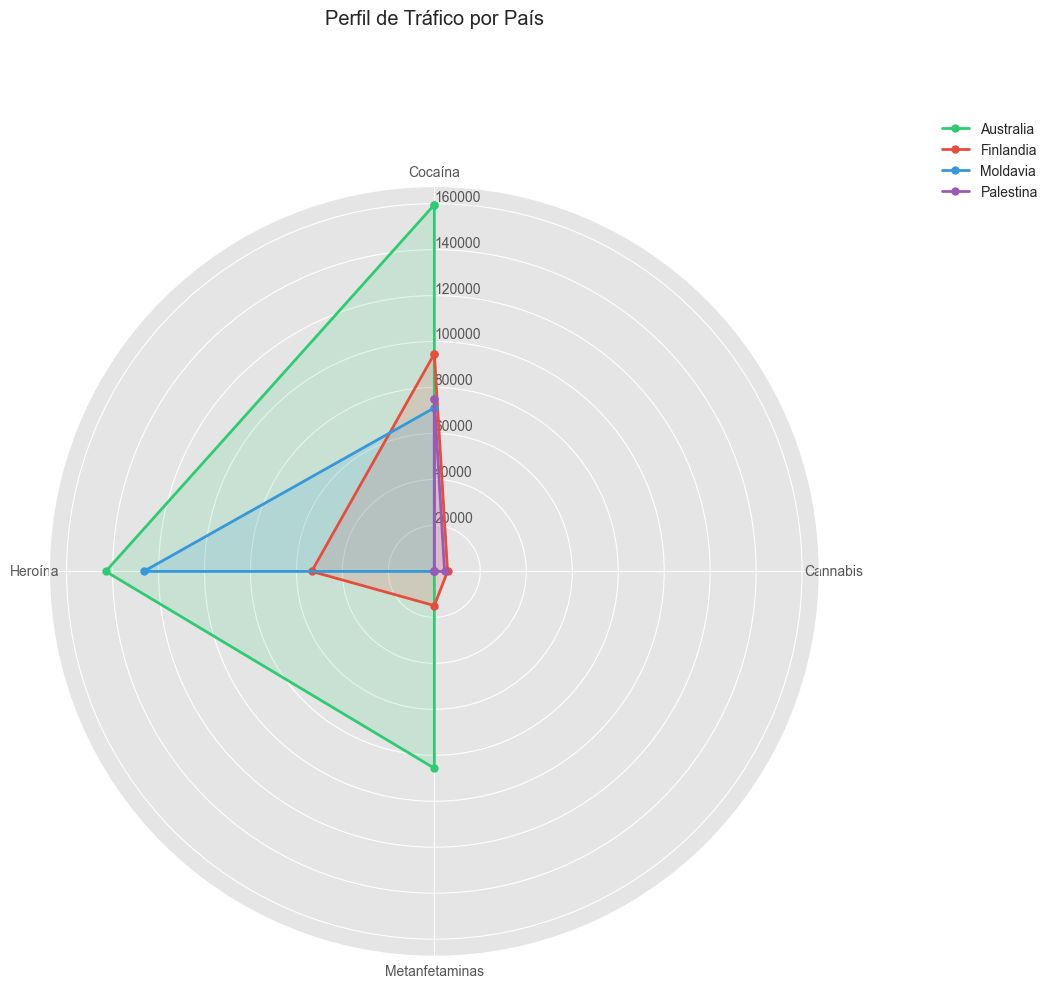

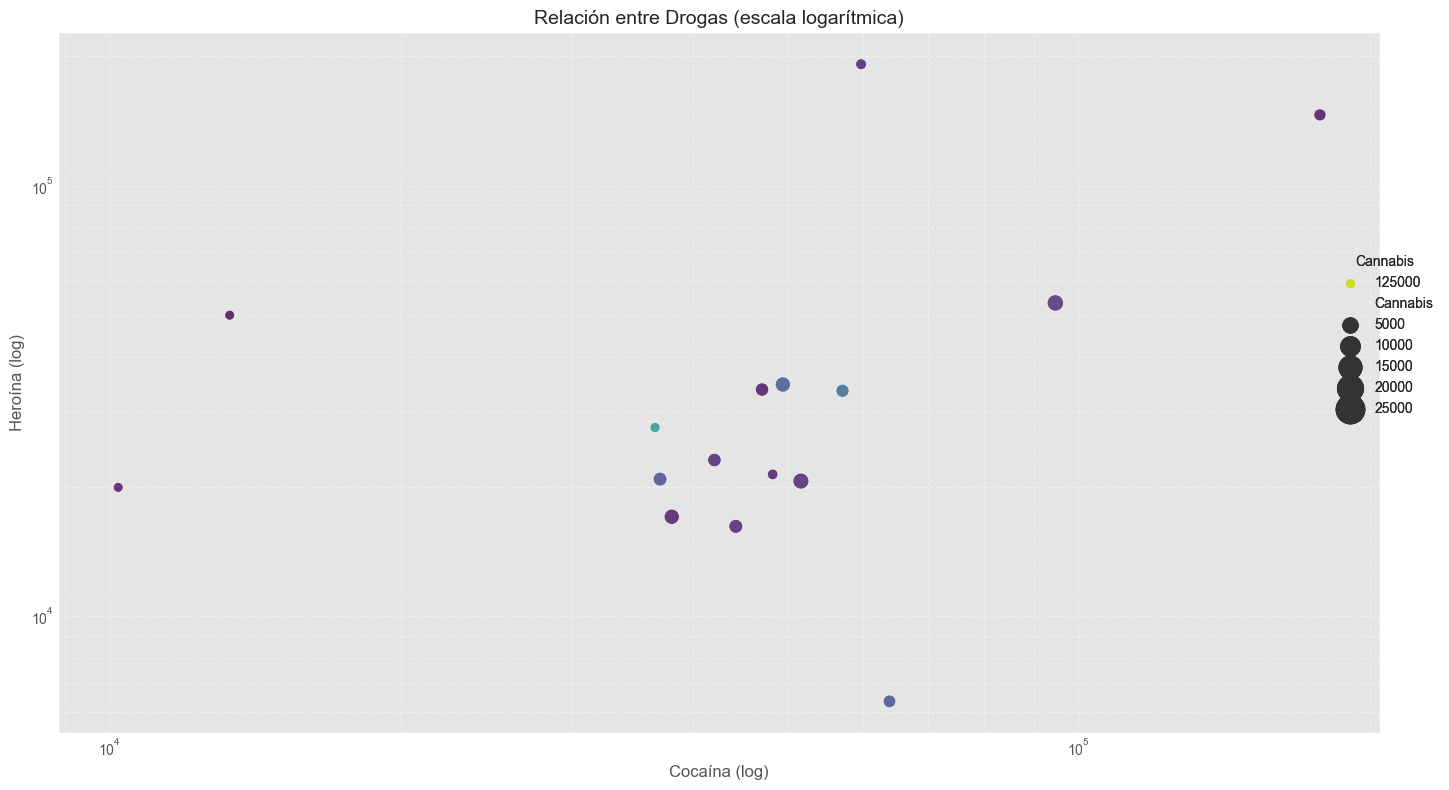

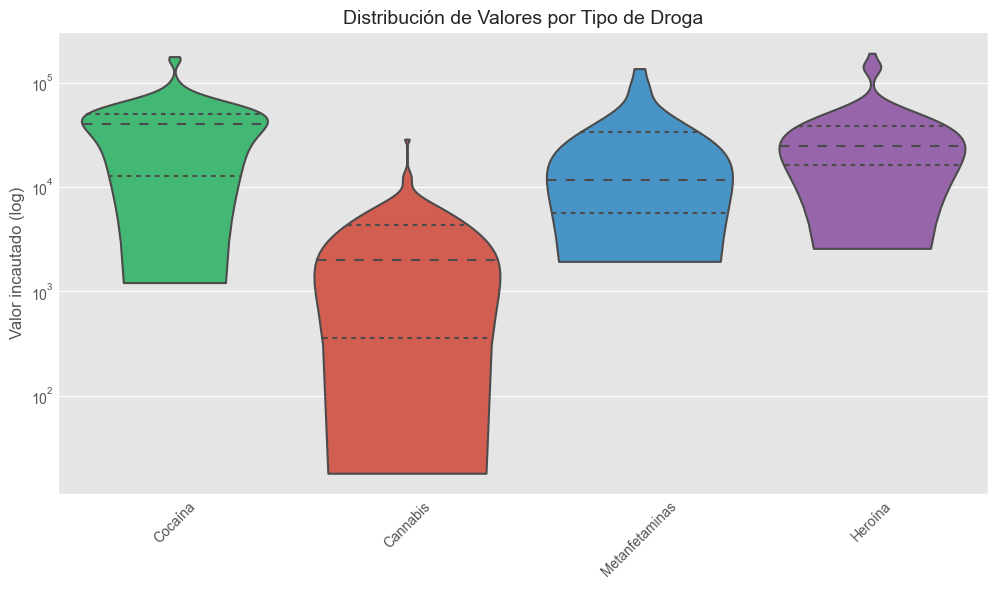

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración estética
plt.style.use('ggplot')
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
sns.set_palette(sns.color_palette(colors))

# 1. Heatmap de distribución por drogas
plt.figure(figsize=(12, 8))
heatmap_data = df_trafico.set_index('País').dropna(how='all')
sns.heatmap(heatmap_data.T, 
           cmap='YlGnBu',
           mask=heatmap_data.T.isnull(),
           cbar_kws={'label': 'Cantidad incautada (USD)'})
plt.title('Distribución de Drogas por País', fontsize=14)
plt.xlabel('País')
plt.ylabel('Tipo de Droga')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Radar chart para comparación multidroga
from math import pi

def plot_radar_chart(countries):
    categories = df_trafico.columns[1:]
    N = len(categories)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    for idx, country in enumerate(countries):
        values = df_trafico[df_trafico['País'] == country].iloc[:,1:].fillna(0).values[0]
        values = np.append(values, values[:1])
        
        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', 
               label=country, marker='o', markersize=5)
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Perfil de Tráfico por País', y=1.2)
    plt.show()

plot_radar_chart(['Australia', 'Finlandia', 'Moldavia', 'Palestina'])

# 3. Bubble Plot multivariable
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=df_trafico, 
                    x='Cocaína', 
                    y='Heroína',
                    size='Cannabis',
                    hue='Metanfetaminas',
                    sizes=(50, 500),
                    alpha=0.8,
                    palette='viridis')

# Ajuste de leyendas
h, l = ax.get_legend_handles_labels()
plt.legend(h[1:5], l[1:5], 
          bbox_to_anchor=(1.05, 1), 
          title='Metanfetaminas',
          borderaxespad=0)

size_legend = plt.legend(h[5:], l[5:], 
                        bbox_to_anchor=(1.05, 0.7),
                        title='Cannabis',
                        frameon=False)

ax.add_artist(size_legend)

plt.xscale('log')
plt.yscale('log')
plt.title('Relación entre Drogas (escala logarítmica)', fontsize=14)
plt.xlabel('Cocaína (log)')
plt.ylabel('Heroína (log)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. Gráfico de violín para distribución por droga
melted_df = df_trafico.melt(id_vars='País', var_name='Droga', value_name='Valor')
plt.figure(figsize=(12, 6))
sns.violinplot(data=melted_df.dropna(), 
              x='Droga', 
              y='Valor',
              inner='quartile',
              cut=0,
              scale='width')
plt.yscale('log')
plt.title('Distribución de Valores por Tipo de Droga', fontsize=14)
plt.xlabel('')
plt.ylabel('Valor incautado (log)')
plt.xticks(rotation=45)
plt.show()

# Mercado

In [9]:
df_mercado = pd.read_csv('../data/mercado.csv')

In [10]:
df_mercado

,País,Población,Consumo_Tn,Mercado_USD
0,Estados Unidos,7409071,614.952893,1.875606e+10
1,Brasil,4488953,372.583099,9.314577e+08
2,India,1300000,107.900000,6.438035e+09
3,España,1056208,87.665264,3.748080e+09
4,Alemania,831375,69.004125,3.039619e+09
5,Francia,795088,65.992304,2.544187e+09
6,México,784635,65.124705,6.643807e+08
7,Australia,668847,55.514301,8.856218e+09
8,Italia,656593,54.497219,2.396256e+09
9,Argentina,506004,41.998332,2.099917e+08


Resumen estadístico:
        Población Consumo_Tn     Mercado_USD    USD_por_Tn
count       36.00      36.00           36.00         36.00
mean    587899.11      48.80   1477344388.63   34673026.94
std    1404069.32     116.54   3522142045.08   29898484.43
min       6480.00       0.54      4145815.94    1215060.00
25%      40275.00       3.34     48706068.80    7927067.50
50%     116991.50       9.71    187346360.13   38533615.00
75%     543651.25      45.12    797889928.44   45225390.00
max    7409071.00     614.95  18756063236.50  159530390.00


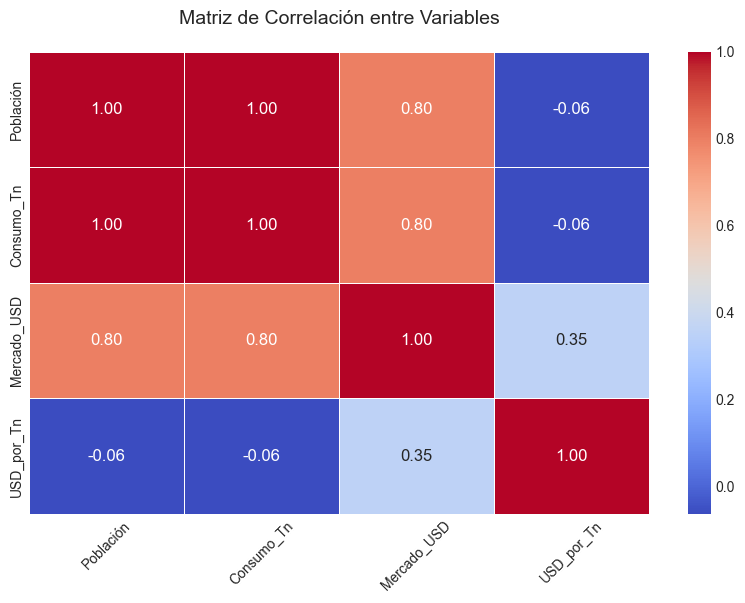

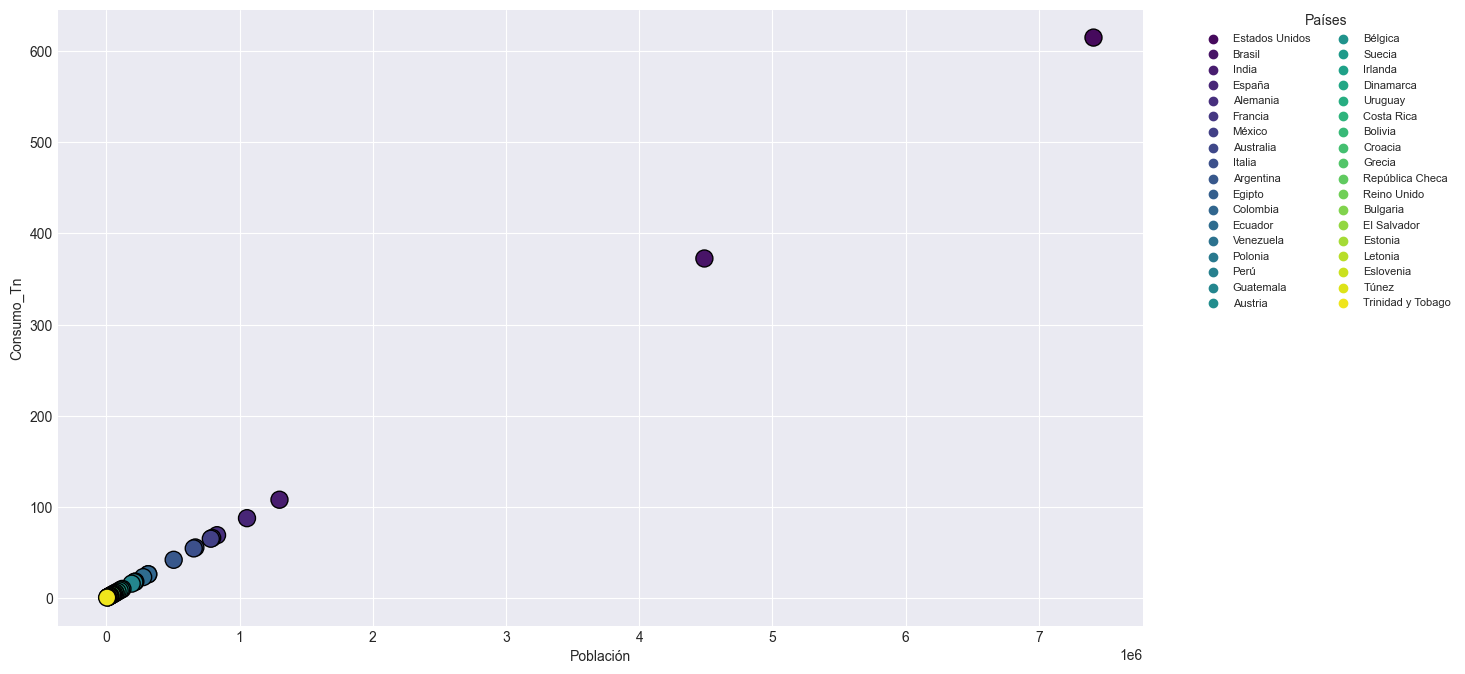

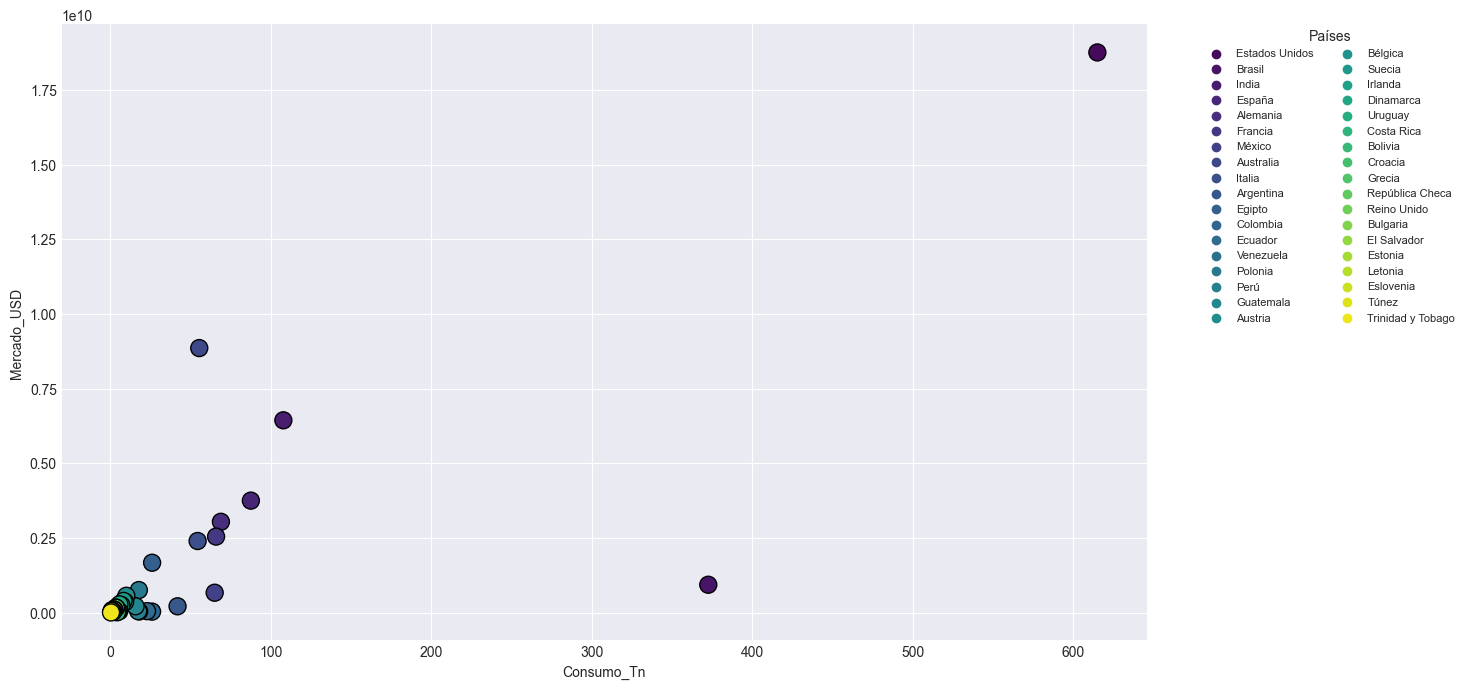

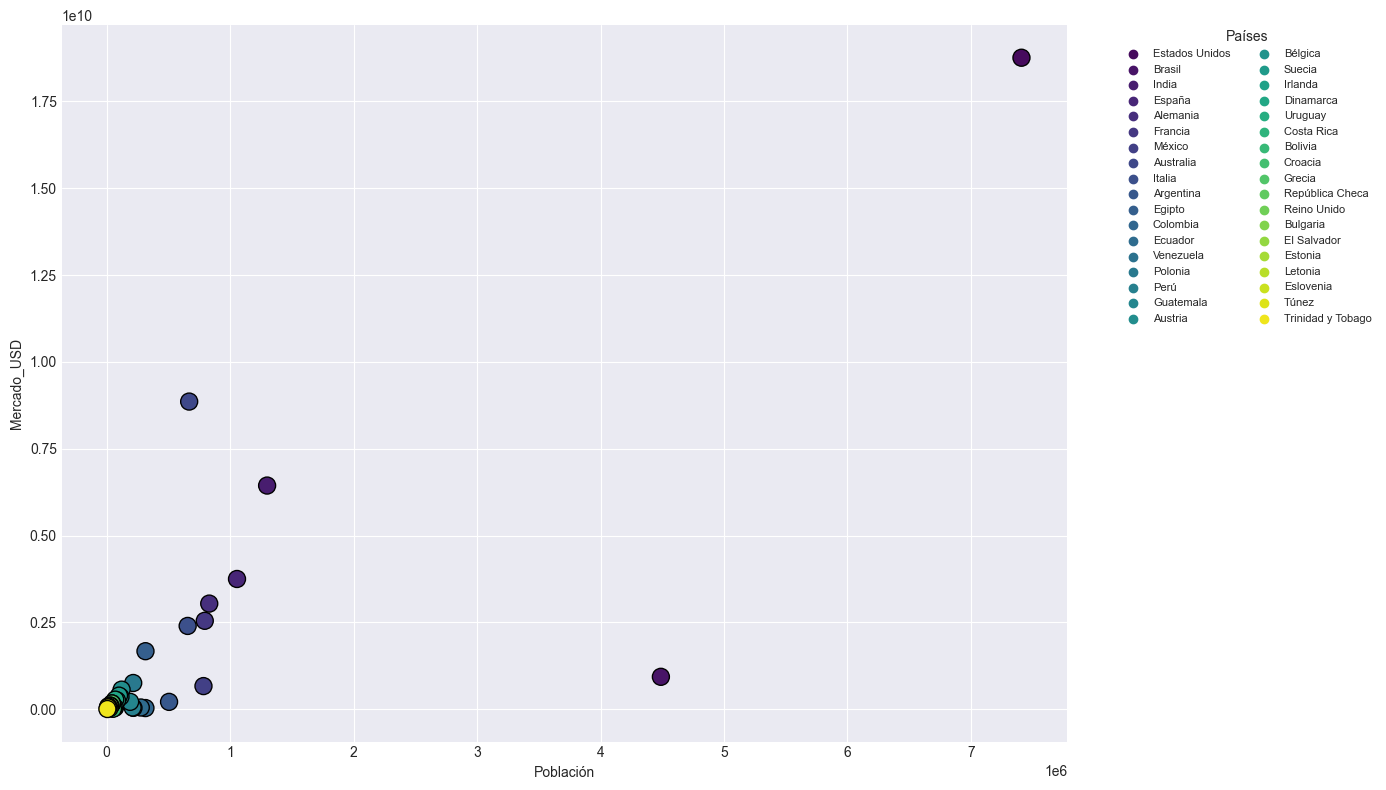

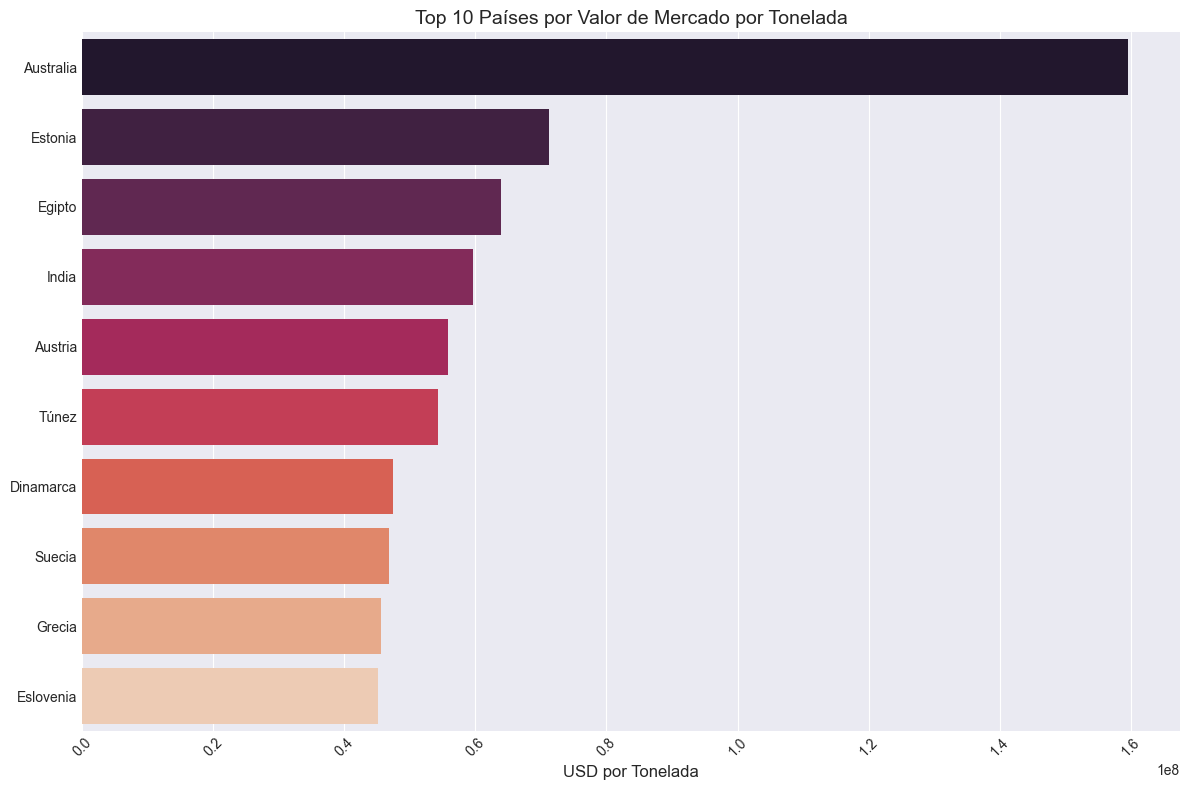

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de estilo
plt.style.use('seaborn-darkgrid')
palette = sns.color_palette("viridis", n_colors=len(df_mercado))

# 1. Análisis estadístico básico
print("Resumen estadístico:")
print(df_mercado.describe().apply(lambda x: x.apply("{0:.2f}".format)))

# 2. Matriz de correlación
corr_matrix = df_mercado.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size":12}, linewidths=0.5)
plt.title("Matriz de Correlación entre Variables", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.show()

# 3. Scatter Plots con transformación logarítmica
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=df_mercado, x='Población', y='Consumo_Tn', 
                    hue='País', palette=palette, s=150, edgecolor='black')


handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Relación Población vs Consumo (escala logarítmica)", fontsize=12)
axes[0].set_xlabel("Población (log)", fontsize=10)
axes[0].set_ylabel("Consumo en Toneladas (log)", fontsize=10)

# Consumo vs Valor de Mercado
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_mercado, x='Consumo_Tn', y='Mercado_USD', 
                hue='País', palette=palette, s=150, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Relación Consumo vs Valor de Mercado (escala logarítmica)", fontsize=12)
axes[1].set_xlabel("Consumo en Toneladas (log)", fontsize=10)
axes[1].set_ylabel("Valor de Mercado USD (log)", fontsize=10)

# Población vs Valor de Mercado
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_mercado, x='Población', y='Mercado_USD', 
                hue='País', palette=palette, s=150, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title("Relación Población vs Valor de Mercado (escala logarítmica)", fontsize=12)
axes[2].set_xlabel("Población (log)", fontsize=10)
axes[2].set_ylabel("Valor de Mercado USD (log)", fontsize=10)

plt.tight_layout()
plt.show()

# 4. Análisis de valor por tonelada
df_mercado['USD_por_Tn'] = df_mercado['Mercado_USD'] / df_mercado['Consumo_Tn']
top_countries = df_mercado.sort_values('USD_por_Tn', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_countries, x='USD_por_Tn', y='País', palette='rocket')
plt.title("Top 10 Países por Valor de Mercado por Tonelada", fontsize=14)
plt.xlabel("USD por Tonelada", fontsize=12)
plt.ylabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafos

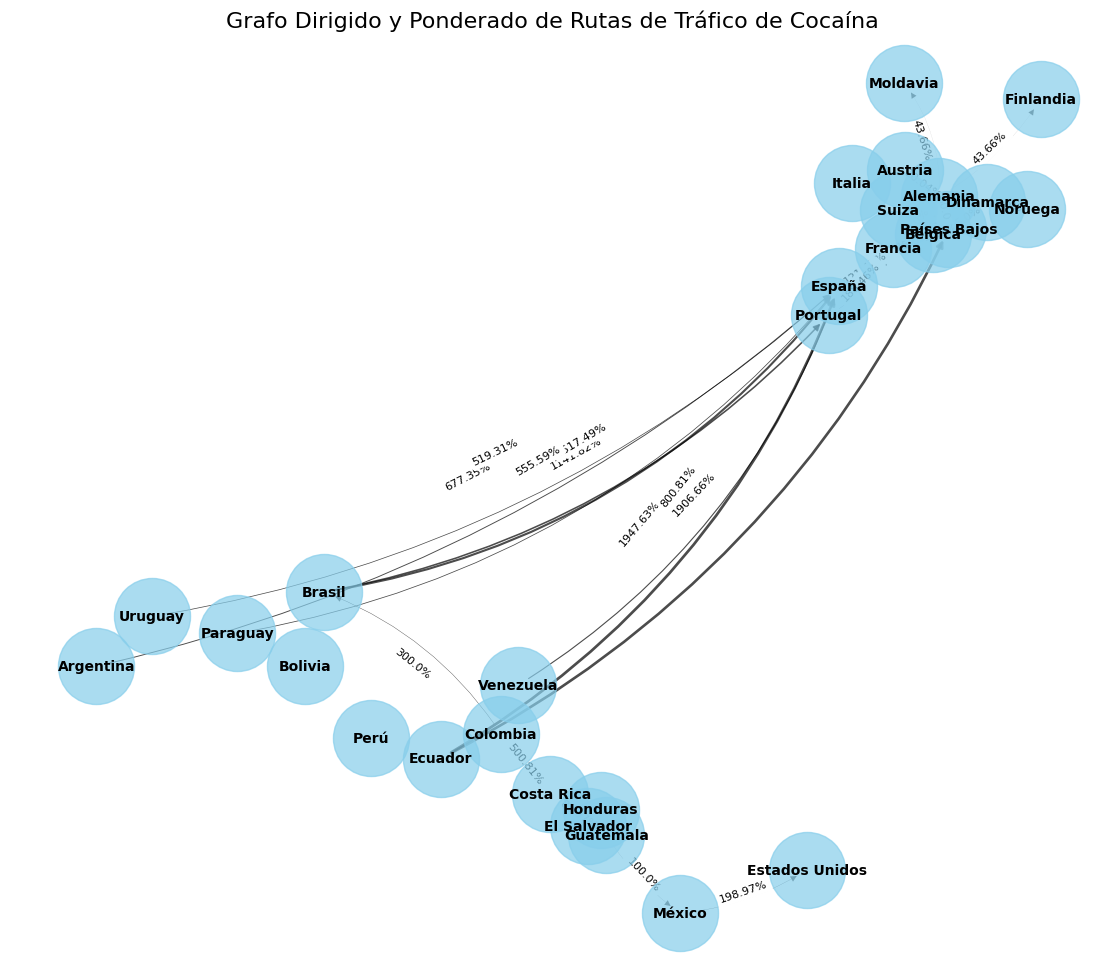

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

country_coordinates = {
    'Colombia': (4.5709, -74.2973),
    'Perú': (-9.189967, -75.015152),
    'Bolivia': (-16.290154, -63.588653),
    'México': (23.634501, -102.552784),
    'Costa Rica': (9.748917, -83.753428),
    'Guatemala': (15.783471, -90.230759),
    'Honduras': (15.199999, -86.241905),
    'El Salvador': (13.794185, -88.89653),
    'Estados Unidos': (37.09024, -95.712891),
    'Brasil': (-14.235004, -51.92528),
    'Ecuador': (-1.831239, -78.183406),
    'Venezuela': (6.42375, -66.58973),
    'Argentina': (-38.416097, -63.616672),
    'Paraguay': (-23.442503, -58.443832),
    'Uruguay': (-32.522779, -55.765835),
    'España': (40.463667, -3.74922),
    'Portugal': (39.399872, -8.224454),
    'Bélgica': (50.503887, 4.469936),
    'Países Bajos': (52.132633, 5.291266),
    'Alemania': (51.165691, 10.451526),
    'Finlandia': (61.92411, 25.748151),
    'Moldavia': (47.411631, 28.369885),
    'Austria': (47.516231, 14.550072),
    'Noruega': (60.472024, 8.468946),
    'Francia': (46.227638, 2.213749),
    'Italia': (41.87194, 12.56738),
    'Suiza': (46.818188, 8.227512),
    'Dinamarca': (56.26392, 9.501785)
}

G = nx.DiGraph()

for country, coords in country_coordinates.items():
    G.add_node(country, pos=coords)

rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),  # Colombia → Costa Rica: 500.81% de incremento
    ('Costa Rica', 'Guatemala', 81.97),  # Costa Rica → Guatemala: 81.97% de incremento
    ('Guatemala', 'México', 100.0),     # Ejemplo: Guatemala → México: 100% de incremento
    ('México', 'Estados Unidos', 198.97),  # México → Estados Unidos: 198.97% de incremento
    ('Colombia', 'Brasil', 300.0),      # Ejemplo: Colombia → Brasil: 300% de incremento
    ('Brasil', 'Portugal', 1141.82),    # Brasil → Portugal: 1141.82% de incremento
    ('Brasil', 'España', 1517.49),      # Brasil → España: 1517.49% de incremento
    ('Ecuador', 'España', 1947.63),     # Ecuador → España: 1947.63% de incremento
    ('Ecuador', 'Países Bajos', 1906.66),  # Ecuador → Países Bajos: 1906.66% de incremento
    ('Venezuela', 'España', 800.81),    # Venezuela → España: 800.81% de incremento
    ('Argentina', 'España', 677.35),    # Argentina → España: 677.35% de incremento
    ('Paraguay', 'España', 555.59),     # Paraguay → España: 555.59% de incremento
    ('Uruguay', 'España', 519.31),      # Uruguay → España: 519.31% de incremento
    ('Portugal', 'Francia', 188.46),    # Portugal → Francia: 188.46% de incremento
    ('España', 'Francia', 121.47),      # España → Francia: 121.47% de incremento
    ('Francia', 'Alemania', 50.0),      # Ejemplo: Francia → Alemania: 50% de incremento
    ('Alemania', 'Austria', 20.04),     # Alemania → Austria: 20.04% de incremento
    ('Alemania', 'Finlandia', 43.66),   # Alemania → Finlandia: 43.66% de incremento
    ('Países Bajos', 'Alemania', 30.0), # Ejemplo: Países Bajos → Alemania: 30% de incremento
    ('Bélgica', 'Alemania', 25.0),      # Ejemplo: Bélgica → Alemania: 25% de incremento
    ('Bélgica', 'Francia', 15.0),       # Ejemplo: Bélgica → Francia: 15% de incremento
    ('Países Bajos', 'Bélgica', 10.0),  # Ejemplo: Países Bajos → Bélgica: 10% de incremento
    ('Países Bajos', 'Dinamarca', 5.0), # Ejemplo: Países Bajos → Dinamarca: 5% de incremento
    ('Dinamarca', 'Noruega', 3.0),      # Ejemplo: Dinamarca → Noruega: 3% de incremento
    ('Alemania', 'Moldavia', 43.66)     # Alemania → Moldavia: 43.66% de incremento
]

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])  # Añadir arista con ponderación

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(14, 12))

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.7)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

edge_weights = nx.get_edge_attributes(G, 'weight')

for edge, weight in edge_weights.items():
    u, v = edge
    x_values = [pos[u][1]*10, pos[v][1]*10]  # Longitudes (x)
    y_values = [pos[u][0]*10, pos[v][0]*10]  # Latitudes (y)

    curvature = 0.1 * np.random.uniform(1, 2)  # Control de la curvatura de las aristas
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weight / 1000, alpha=0.7, edge_color='black', style='solid', connectionstyle=f'arc3,rad={curvature}')

edge_labels = {(u, v): f"{d['weight']}%" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo Dirigido y Ponderado de Rutas de Tráfico de Cocaína", fontsize=16)
plt.axis('off')
plt.show()

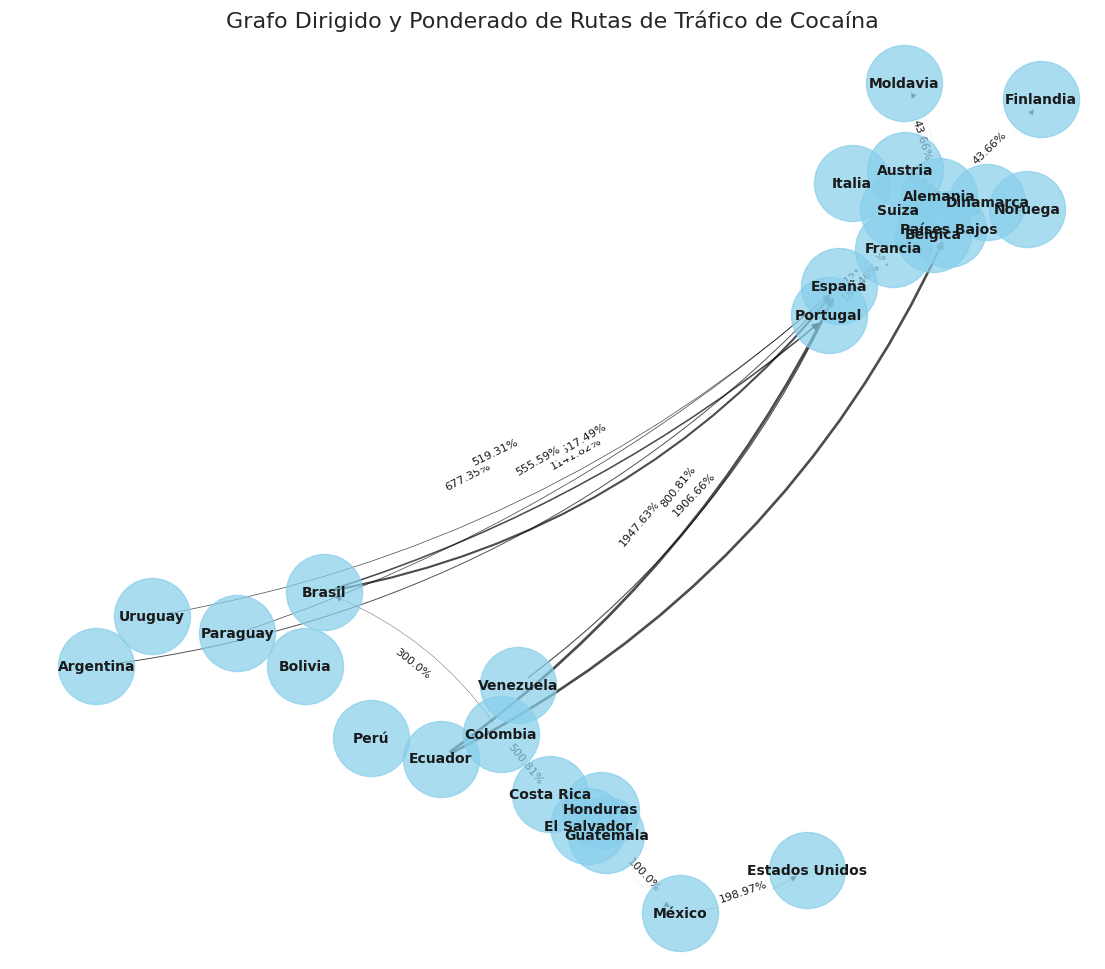

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Diccionario con las coordenadas geográficas de los países (latitud, longitud)
country_coordinates = {
    'Colombia': (4.5709, -74.2973),
    'Perú': (-9.189967, -75.015152),
    'Bolivia': (-16.290154, -63.588653),
    'México': (23.634501, -102.552784),
    'Costa Rica': (9.748917, -83.753428),
    'Guatemala': (15.783471, -90.230759),
    'Honduras': (15.199999, -86.241905),
    'El Salvador': (13.794185, -88.89653),
    'Estados Unidos': (37.09024, -95.712891),
    'Brasil': (-14.235004, -51.92528),
    'Ecuador': (-1.831239, -78.183406),
    'Venezuela': (6.42375, -66.58973),
    'Argentina': (-38.416097, -63.616672),
    'Paraguay': (-23.442503, -58.443832),
    'Uruguay': (-32.522779, -55.765835),
    'España': (40.463667, -3.74922),
    'Portugal': (39.399872, -8.224454),
    'Bélgica': (50.503887, 4.469936),
    'Países Bajos': (52.132633, 5.291266),
    'Alemania': (51.165691, 10.451526),
    'Finlandia': (61.92411, 25.748151),
    'Moldavia': (47.411631, 28.369885),
    'Austria': (47.516231, 14.550072),
    'Noruega': (60.472024, 8.468946),
    'Francia': (46.227638, 2.213749),
    'Italia': (41.87194, 12.56738),
    'Suiza': (46.818188, 8.227512),
    'Dinamarca': (56.26392, 9.501785)
}

# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir los nodos con sus coordenadas
for country, coords in country_coordinates.items():
    G.add_node(country, pos=coords)

# Añadir las aristas basadas en las rutas de tráfico y sus ponderaciones (incremento de precio)
rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),
    ('Costa Rica', 'Guatemala', 81.97),
    ('Guatemala', 'México', 100.0),
    ('México', 'Estados Unidos', 198.97),
    ('Colombia', 'Brasil', 300.0),
    ('Brasil', 'Portugal', 1141.82),
    ('Brasil', 'España', 1517.49),
    ('Ecuador', 'España', 1947.63),
    ('Ecuador', 'Países Bajos', 1906.66),
    ('Venezuela', 'España', 800.81),
    ('Argentina', 'España', 677.35),
    ('Paraguay', 'España', 555.59),
    ('Uruguay', 'España', 519.31),
    ('Portugal', 'Francia', 188.46),
    ('España', 'Francia', 121.47),
    ('Francia', 'Alemania', 50.0),
    ('Alemania', 'Austria', 20.04),
    ('Alemania', 'Finlandia', 43.66),
    ('Países Bajos', 'Alemania', 30.0),
    ('Bélgica', 'Alemania', 25.0),
    ('Bélgica', 'Francia', 15.0),
    ('Países Bajos', 'Bélgica', 10.0),
    ('Países Bajos', 'Dinamarca', 5.0),
    ('Dinamarca', 'Noruega', 3.0),
    ('Alemania', 'Moldavia', 43.66)
]

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])  # Añadir arista con ponderación

# Obtener las posiciones de los nodos (coordenadas geográficas)
pos = nx.get_node_attributes(G, 'pos')

# Configurar el tamaño de la figura
plt.figure(figsize=(14, 12))

# Dibujar los nodos con un color más atractivo y tamaño adecuado
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.7)

# Dibujar las etiquetas de los nodos (países)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Dibujar las aristas con grosor proporcional a la ponderación y mayor suavidad
edge_weights = nx.get_edge_attributes(G, 'weight')

# Personalizar la estética de las aristas con un color más suave y curvado
for edge, weight in edge_weights.items():
    u, v = edge
    x_values = [pos[u][1], pos[v][1]]  # Longitudes (x)
    y_values = [pos[u][0], pos[v][0]]  # Latitudes (y)

    # Hacer las aristas curvadas para una mejor visualización
    curvature = 0.1 * np.random.uniform(1, 2)  # Control de la curvatura de las aristas
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weight / 1000, alpha=0.7, edge_color='black', style='solid', connectionstyle=f'arc3,rad={curvature}')

# Dibujar las etiquetas de las aristas (ponderaciones) con mayor claridad
edge_labels = {(u, v): f"{d['weight']}%" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Título y ajustes finales
plt.title("Grafo Dirigido y Ponderado de Rutas de Tráfico de Cocaína", fontsize=16)
plt.axis('off')  # Desactivar el eje para una mejor visualización
plt.show()


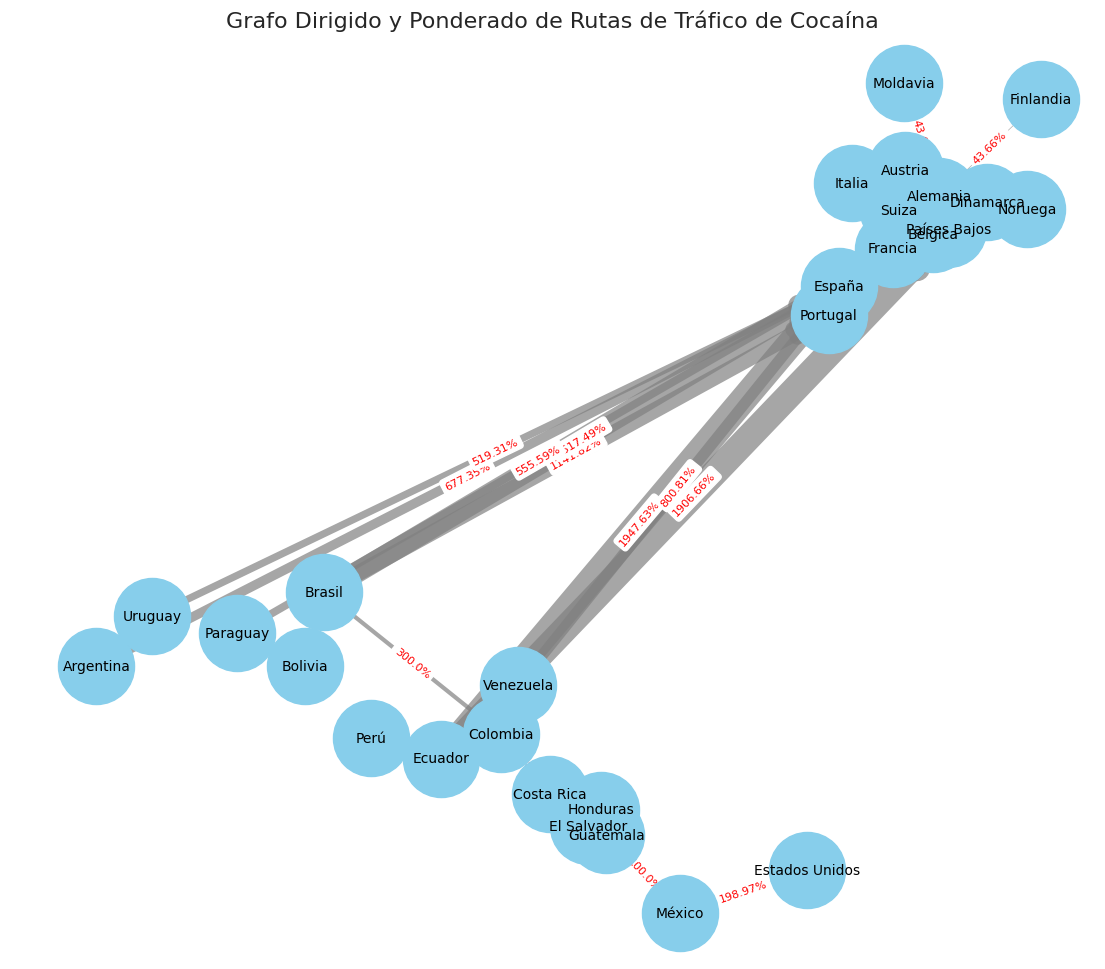

In [60]:
import networkx as nx
import matplotlib.pyplot as plt

# Diccionario con las coordenadas geográficas de los países (latitud, longitud)
country_coordinates = {
    'Colombia': (4.5709, -74.2973),
    'Perú': (-9.189967, -75.015152),
    'Bolivia': (-16.290154, -63.588653),
    'México': (23.634501, -102.552784),
    'Costa Rica': (9.748917, -83.753428),
    'Guatemala': (15.783471, -90.230759),
    'Honduras': (15.199999, -86.241905),
    'El Salvador': (13.794185, -88.89653),
    'Estados Unidos': (37.09024, -95.712891),
    'Brasil': (-14.235004, -51.92528),
    'Ecuador': (-1.831239, -78.183406),
    'Venezuela': (6.42375, -66.58973),
    'Argentina': (-38.416097, -63.616672),
    'Paraguay': (-23.442503, -58.443832),
    'Uruguay': (-32.522779, -55.765835),
    'España': (40.463667, -3.74922),
    'Portugal': (39.399872, -8.224454),
    'Bélgica': (50.503887, 4.469936),
    'Países Bajos': (52.132633, 5.291266),
    'Alemania': (51.165691, 10.451526),
    'Finlandia': (61.92411, 25.748151),
    'Moldavia': (47.411631, 28.369885),
    'Austria': (47.516231, 14.550072),
    'Noruega': (60.472024, 8.468946),
    'Francia': (46.227638, 2.213749),
    'Italia': (41.87194, 12.56738),
    'Suiza': (46.818188, 8.227512),
    'Dinamarca': (56.26392, 9.501785)
}

# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir los nodos con sus coordenadas
for country, coords in country_coordinates.items():
    G.add_node(country, pos=coords)

# Añadir las aristas basadas en las rutas de tráfico y sus ponderaciones (incremento de precio)
rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),  # Colombia → Costa Rica: 500.81% de incremento
    ('Costa Rica', 'Guatemala', 81.97),  # Costa Rica → Guatemala: 81.97% de incremento
    ('Guatemala', 'México', 100.0),     # Ejemplo: Guatemala → México: 100% de incremento
    ('México', 'Estados Unidos', 198.97),  # México → Estados Unidos: 198.97% de incremento
    ('Colombia', 'Brasil', 300.0),      # Ejemplo: Colombia → Brasil: 300% de incremento
    ('Brasil', 'Portugal', 1141.82),    # Brasil → Portugal: 1141.82% de incremento
    ('Brasil', 'España', 1517.49),      # Brasil → España: 1517.49% de incremento
    ('Ecuador', 'España', 1947.63),     # Ecuador → España: 1947.63% de incremento
    ('Ecuador', 'Países Bajos', 1906.66),  # Ecuador → Países Bajos: 1906.66% de incremento
    ('Venezuela', 'España', 800.81),    # Venezuela → España: 800.81% de incremento
    ('Argentina', 'España', 677.35),    # Argentina → España: 677.35% de incremento
    ('Paraguay', 'España', 555.59),     # Paraguay → España: 555.59% de incremento
    ('Uruguay', 'España', 519.31),      # Uruguay → España: 519.31% de incremento
    ('Portugal', 'Francia', 188.46),    # Portugal → Francia: 188.46% de incremento
    ('España', 'Francia', 121.47),      # España → Francia: 121.47% de incremento
    ('Francia', 'Alemania', 50.0),      # Ejemplo: Francia → Alemania: 50% de incremento
    ('Alemania', 'Austria', 20.04),     # Alemania → Austria: 20.04% de incremento
    ('Alemania', 'Finlandia', 43.66),   # Alemania → Finlandia: 43.66% de incremento
    ('Países Bajos', 'Alemania', 30.0), # Ejemplo: Países Bajos → Alemania: 30% de incremento
    ('Bélgica', 'Alemania', 25.0),      # Ejemplo: Bélgica → Alemania: 25% de incremento
    ('Bélgica', 'Francia', 15.0),       # Ejemplo: Bélgica → Francia: 15% de incremento
    ('Países Bajos', 'Bélgica', 10.0),  # Ejemplo: Países Bajos → Bélgica: 10% de incremento
    ('Países Bajos', 'Dinamarca', 5.0), # Ejemplo: Países Bajos → Dinamarca: 5% de incremento
    ('Dinamarca', 'Noruega', 3.0),      # Ejemplo: Dinamarca → Noruega: 3% de incremento
    ('Alemania', 'Moldavia', 43.66)     # Alemania → Moldavia: 43.66% de incremento
]

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])  # Añadir arista con ponderación

# Obtener las posiciones de los nodos (coordenadas geográficas)
pos = nx.get_node_attributes(G, 'pos')

# Dibujar el grafo con las posiciones geográficas
plt.figure(figsize=(14, 12))

# Dibujar los nodos
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')

# Dibujar las etiquetas de los nodos
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Dibujar las aristas con grosor proporcional a la ponderación
edge_weights = nx.get_edge_attributes(G, 'weight')
for edge, weight in edge_weights.items():
    nx.draw_networkx_edges(
        G, pos, edgelist=[edge],
        width=weight/100,  # Grosor de la arista proporcional a la ponderación
        alpha=0.7,
        edge_color='gray',
        arrowstyle='->',  # Flechas para indicar dirección
        arrowsize=15
    )

# Dibujar las etiquetas de las aristas (ponderaciones)
edge_labels = {(u, v): f"{d['weight']}%" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

# Ajustar el aspecto del gráfico
plt.title("Grafo Dirigido y Ponderado de Rutas de Tráfico de Cocaína", fontsize=16)
plt.axis('off')  # Ocultar los ejes
plt.show()

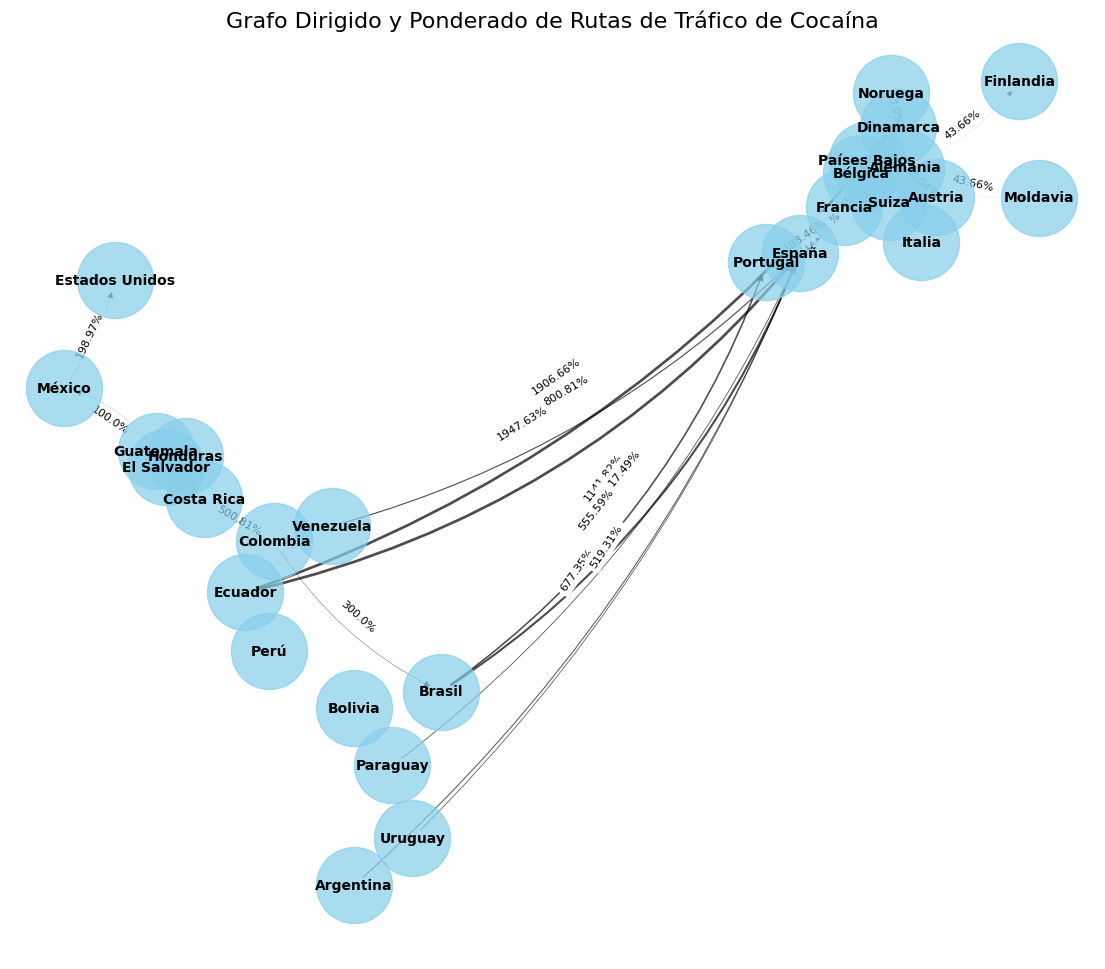

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Diccionario con las coordenadas geográficas de los países (latitud, longitud)
country_coordinates = {
    'Colombia': (4.5709, -74.2973),
    'Perú': (-9.189967, -75.015152),
    'Bolivia': (-16.290154, -63.588653),
    'México': (23.634501, -102.552784),
    'Costa Rica': (9.748917, -83.753428),
    'Guatemala': (15.783471, -90.230759),
    'Honduras': (15.199999, -86.241905),
    'El Salvador': (13.794185, -88.89653),
    'Estados Unidos': (37.09024, -95.712891),
    'Brasil': (-14.235004, -51.92528),
    'Ecuador': (-1.831239, -78.183406),
    'Venezuela': (6.42375, -66.58973),
    'Argentina': (-38.416097, -63.616672),
    'Paraguay': (-23.442503, -58.443832),
    'Uruguay': (-32.522779, -55.765835),
    'España': (40.463667, -3.74922),
    'Portugal': (39.399872, -8.224454),
    'Bélgica': (50.503887, 4.469936),
    'Países Bajos': (52.132633, 5.291266),
    'Alemania': (51.165691, 10.451526),
    'Finlandia': (61.92411, 25.748151),
    'Moldavia': (47.411631, 28.369885),
    'Austria': (47.516231, 14.550072),
    'Noruega': (60.472024, 8.468946),
    'Francia': (46.227638, 2.213749),
    'Italia': (41.87194, 12.56738),
    'Suiza': (46.818188, 8.227512),
    'Dinamarca': (56.26392, 9.501785)
}

# Calcular los rangos de latitudes y longitudes para normalizar
latitudes = [coords[0] for coords in country_coordinates.values()]
longitudes = [coords[1] for coords in country_coordinates.values()]

# Normalización de las latitudes y longitudes
lat_min, lat_max = min(latitudes), max(latitudes)
long_min, long_max = min(longitudes), max(longitudes)

# Función para normalizar las coordenadas
def normalize_latitude(lat):
    return (lat - lat_min) / (lat_max - lat_min)  # Normalizar latitud al rango [0, 1]

def normalize_longitude(lon):
    return (lon - long_min) / (long_max - long_min)  # Normalizar longitud al rango [0, 1]

# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir los nodos con sus coordenadas normalizadas
for country, coords in country_coordinates.items():
    lat, lon = coords
    normalized_lat = normalize_latitude(lat)
    normalized_lon = normalize_longitude(lon)
    G.add_node(country, pos=(normalized_lon, normalized_lat))  # Invertir latitudes para que el norte esté arriba

# Añadir las aristas basadas en las rutas de tráfico y sus ponderaciones (incremento de precio)
rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),
    ('Costa Rica', 'Guatemala', 81.97),
    ('Guatemala', 'México', 100.0),
    ('México', 'Estados Unidos', 198.97),
    ('Colombia', 'Brasil', 300.0),
    ('Brasil', 'Portugal', 1141.82),
    ('Brasil', 'España', 1517.49),
    ('Ecuador', 'España', 1947.63),
    ('Ecuador', 'Países Bajos', 1906.66),
    ('Venezuela', 'España', 800.81),
    ('Argentina', 'España', 677.35),
    ('Paraguay', 'España', 555.59),
    ('Uruguay', 'España', 519.31),
    ('Portugal', 'Francia', 188.46),
    ('España', 'Francia', 121.47),
    ('Francia', 'Alemania', 50.0),
    ('Alemania', 'Austria', 20.04),
    ('Alemania', 'Finlandia', 43.66),
    ('Países Bajos', 'Alemania', 30.0),
    ('Bélgica', 'Alemania', 25.0),
    ('Bélgica', 'Francia', 15.0),
    ('Países Bajos', 'Bélgica', 10.0),
    ('Países Bajos', 'Dinamarca', 5.0),
    ('Dinamarca', 'Noruega', 3.0),
    ('Alemania', 'Moldavia', 43.66)
]

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])  # Añadir arista con ponderación

# Obtener las posiciones de los nodos (coordenadas normalizadas)
pos = nx.get_node_attributes(G, 'pos')

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(14, 12))

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.7)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

edge_weights = nx.get_edge_attributes(G, 'weight')

for edge, weight in edge_weights.items():
    u, v = edge
    x_values = [pos[u][1], pos[v][1]]  # Longitudes (x)
    y_values = [pos[u][0], pos[v][0]]  # Latitudes (y)

    curvature = 0.1 * np.random.uniform(1, 2)  # Control de la curvatura de las aristas
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weight / 1000, alpha=0.7, edge_color='black', style='solid', connectionstyle=f'arc3,rad={curvature}')

edge_labels = {(u, v): f"{d['weight']}%" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo Dirigido y Ponderado de Rutas de Tráfico de Cocaína", fontsize=16)
plt.axis('off')
plt.show()

In [8]:
! pip install cartopy

  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      proj executable not found. Please set the PROJ_DIR variable. For more information see: https://pyproj4.github.io/pyproj/stable/installation.html
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Configuración del mapa
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#2d2d2d')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#1a1a1a')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edge_color='#7c7c7c')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5, edge_color='#7c7c7c')

# Dibujar nodos con coordenadas reales
node_colors = ['#ff6b6b' if country in ['Colombia', 'Perú', 'Bolivia'] else '#4ecdc4' for country in G.nodes()]
node_sizes = [3500 if country in ['Estados Unidos', 'España', 'Países Bajos'] else 2500 for country in G.nodes()]

for country, (lon, lat) in country_coordinates.items():
    plt.plot(lon, lat, 'o', 
             markersize=node_sizes[list(G.nodes()).index(country)]/300,
             color=node_colors[list(G.nodes()).index(country)],
             alpha=0.9,
             transform=ccrs.Geodetic())
    
    plt.text(lon + 2, lat, country, 
             color='white',
             fontsize=9,
             transform=ccrs.Geodetic(),
             bbox=dict(facecolor='#333333', alpha=0.7, pad=1, edgecolor='none'))

# Dibujar aristas con curvatura geodésica
for edge in G.edges(data=True):
    origin = country_coordinates[edge[0]]
    dest = country_coordinates[edge[1]]
    
    # Curvatura proporcional al peso
    n_points = 100
    lons = np.linspace(origin[1], dest[1], n_points)
    lats = np.linspace(origin[0], dest[0], n_points)
    
    offset = np.sin(np.linspace(0, np.pi, n_points)) * (edge[2]['weight']/500)
    lats = lats + offset * 8  # Ajuste de curvatura
    
    plt.plot(lons, lats, 
             color='#ff9f43',
             linewidth=edge[2]['weight']/200 + 0.5,
             alpha=0.6,
             transform=ccrs.Geodetic())
    
    # Etiquetas de peso
    plt.text(dest[1] + 3, dest[0] - 1, 
             f"+{edge[2]['weight']}%", 
             color='#ff9f43',
             fontsize=8,
             transform=ccrs.Geodetic())

# Elementos decorativos
plt.title("Rutas Globales del Narcotráfico\nIncremento porcentual en precios por ruta", 
          fontsize=20, color='white', pad=20)
plt.figtext(0.5, 0.05, "Fuente: Datos de inteligencia antidrogas 2018-2023", 
            ha='center', color='#7c7c7c')

# Leyenda personalizada
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Países productores', markersize=10, markerfacecolor='#ff6b6b'),
    plt.Line2D([0], [0], marker='o', color='w', label='Países consumidores', markersize=10, markerfacecolor='#4ecdc4'),
    plt.Line2D([0], [0], color='#ff9f43', lw=2, label='Ruta de tráfico (grosor = incremento de precio)')
]

ax.legend(handles=legend_elements, loc='lower left', facecolor='#2d2d2d', labelcolor='white')

# Ajustar vista del mapa
ax.set_extent([-150, 40, -60, 60], crs=ccrs.PlateCarree())

plt.savefig('narcotrafico_map.jpg', dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
plt.show()

ModuleNotFoundError: No module named 'cartopy'